# V. Modeling

In [104]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
from matplotlib.colors import LogNorm
from math import sqrt
from scipy.stats import skew
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import datetime



pd.options.display.max_columns = None
pd.options.display.max_rows = None

Here we are importing the data from the csv file

In [123]:
# load dataset
df = pd.read_csv('data_seloger_EDA_part3.csv')

In [124]:
df.shape

(1860, 71)

The dataset contains only of 1860 observations and 70 features. It can be challenging to build powerful machine learning models from so little data. When we don’t have enough data, it’s very likely to our model have high variance which means overfitting becomes much harder to avoid. 

Also, as discussed in the previous part, a correlation matrix helped us to realize there were many redundant features. We do not want that as if we add redundant information to our model it keeps learning the same thing again and again. One of the vital steps here will be then to reduce the number of features. 

We will do this using XGBoost's inbuilt feature importance functionality.

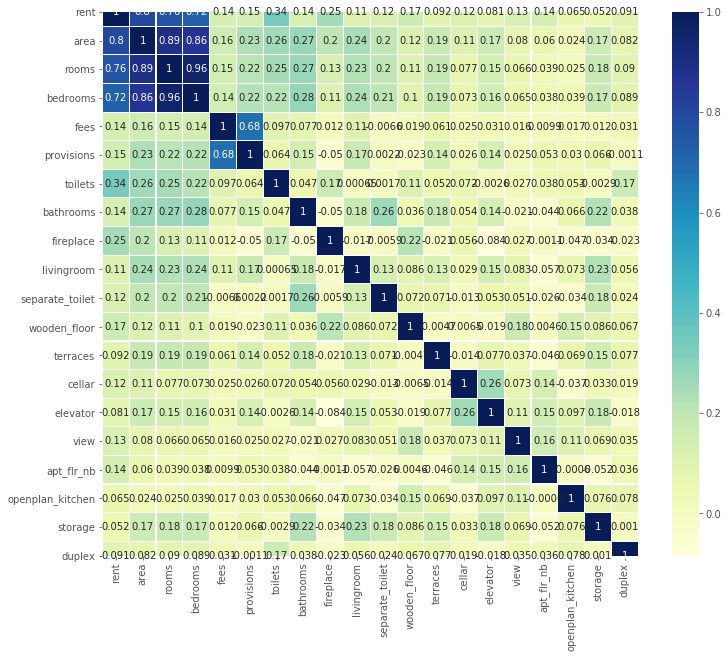

In [125]:
#correlation matrix
k = 20 
corrmat = df.corr(method='spearman')
cols = corrmat.nlargest(k, 'rent')['rent'].index 
  
cm = np.corrcoef(df[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", annot=True,
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values)
plt.show()

## 5.1 Splitting into Training and Validation set

In [126]:
#creating matrices for sklearn:
y = df.rent.values
df.drop(['rent'], axis=1, inplace=True)

X = df

X.shape, y.shape

((1860, 70), (1860,))

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1302, 70)
X_test : (558, 70)
y_train : (1302,)
y_test : (558,)


The first parameter value X denotes the set of predictor data, and y is the target variable. Next, we set random_state=42. This provides for reproducible results, since sci-kit learn’s train_test_split will randomly partition the data. The test_size parameter tells the function what proportion of the data should be in the test partition. 

In this example, about 30% of the data is devoted to the test set.

## 5.2 Data Preparation

We will reduce the number of features using XGBoost's inbuilt feature importance functionality.

In [53]:
#correlation matrix
k = 30 
corrmat = df.corr(method='spearman')
cols = corrmat.nlargest(k, 'rent')['rent'].index 
  
cm = np.corrcoef(df[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", annot=True,
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values)
plt.show()

KeyError: 'rent'

In [ ]:
perform feature selection: This maybe was the most valuable thing to do in this competition, the dataset contained more than 300 features and from a plot of correlation matrix for some features (as there were many features this was done selecting 15 features), a correlation matrix helped us to realize there were many redundant features and this is bad, if we add redundant information to our model it keeps learning the same thing again and again and that doesn’t help, whenever it’s possible we want to remove redundant features.

One of the vital steps here is to reduce the number of features. 
We will do this using XGBoost's inbuilt feature importance functionality.

In [28]:
xg_reg = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [42]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

AttributeError: 'Booster' object has no attribute 'fit'

In [43]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 2.121489


In [44]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[18:00:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:00:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5.412972,0.009467,5.412942,0.021868
1,4.874810,0.008649,4.874775,0.022881
2,4.390628,0.007927,4.390589,0.023817
3,3.955057,0.007292,3.955012,0.024686
4,3.563266,0.006739,3.563213,0.025499


In [46]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.189393
Name: test-rmse-mean, dtype: float64


In [47]:
# Convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. You will use this later in the tutorial.
data_dmatrix = xgboost.DMatrix(data=X,label=y)

In [48]:
xg_reg = xgboost.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[18:00:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this.

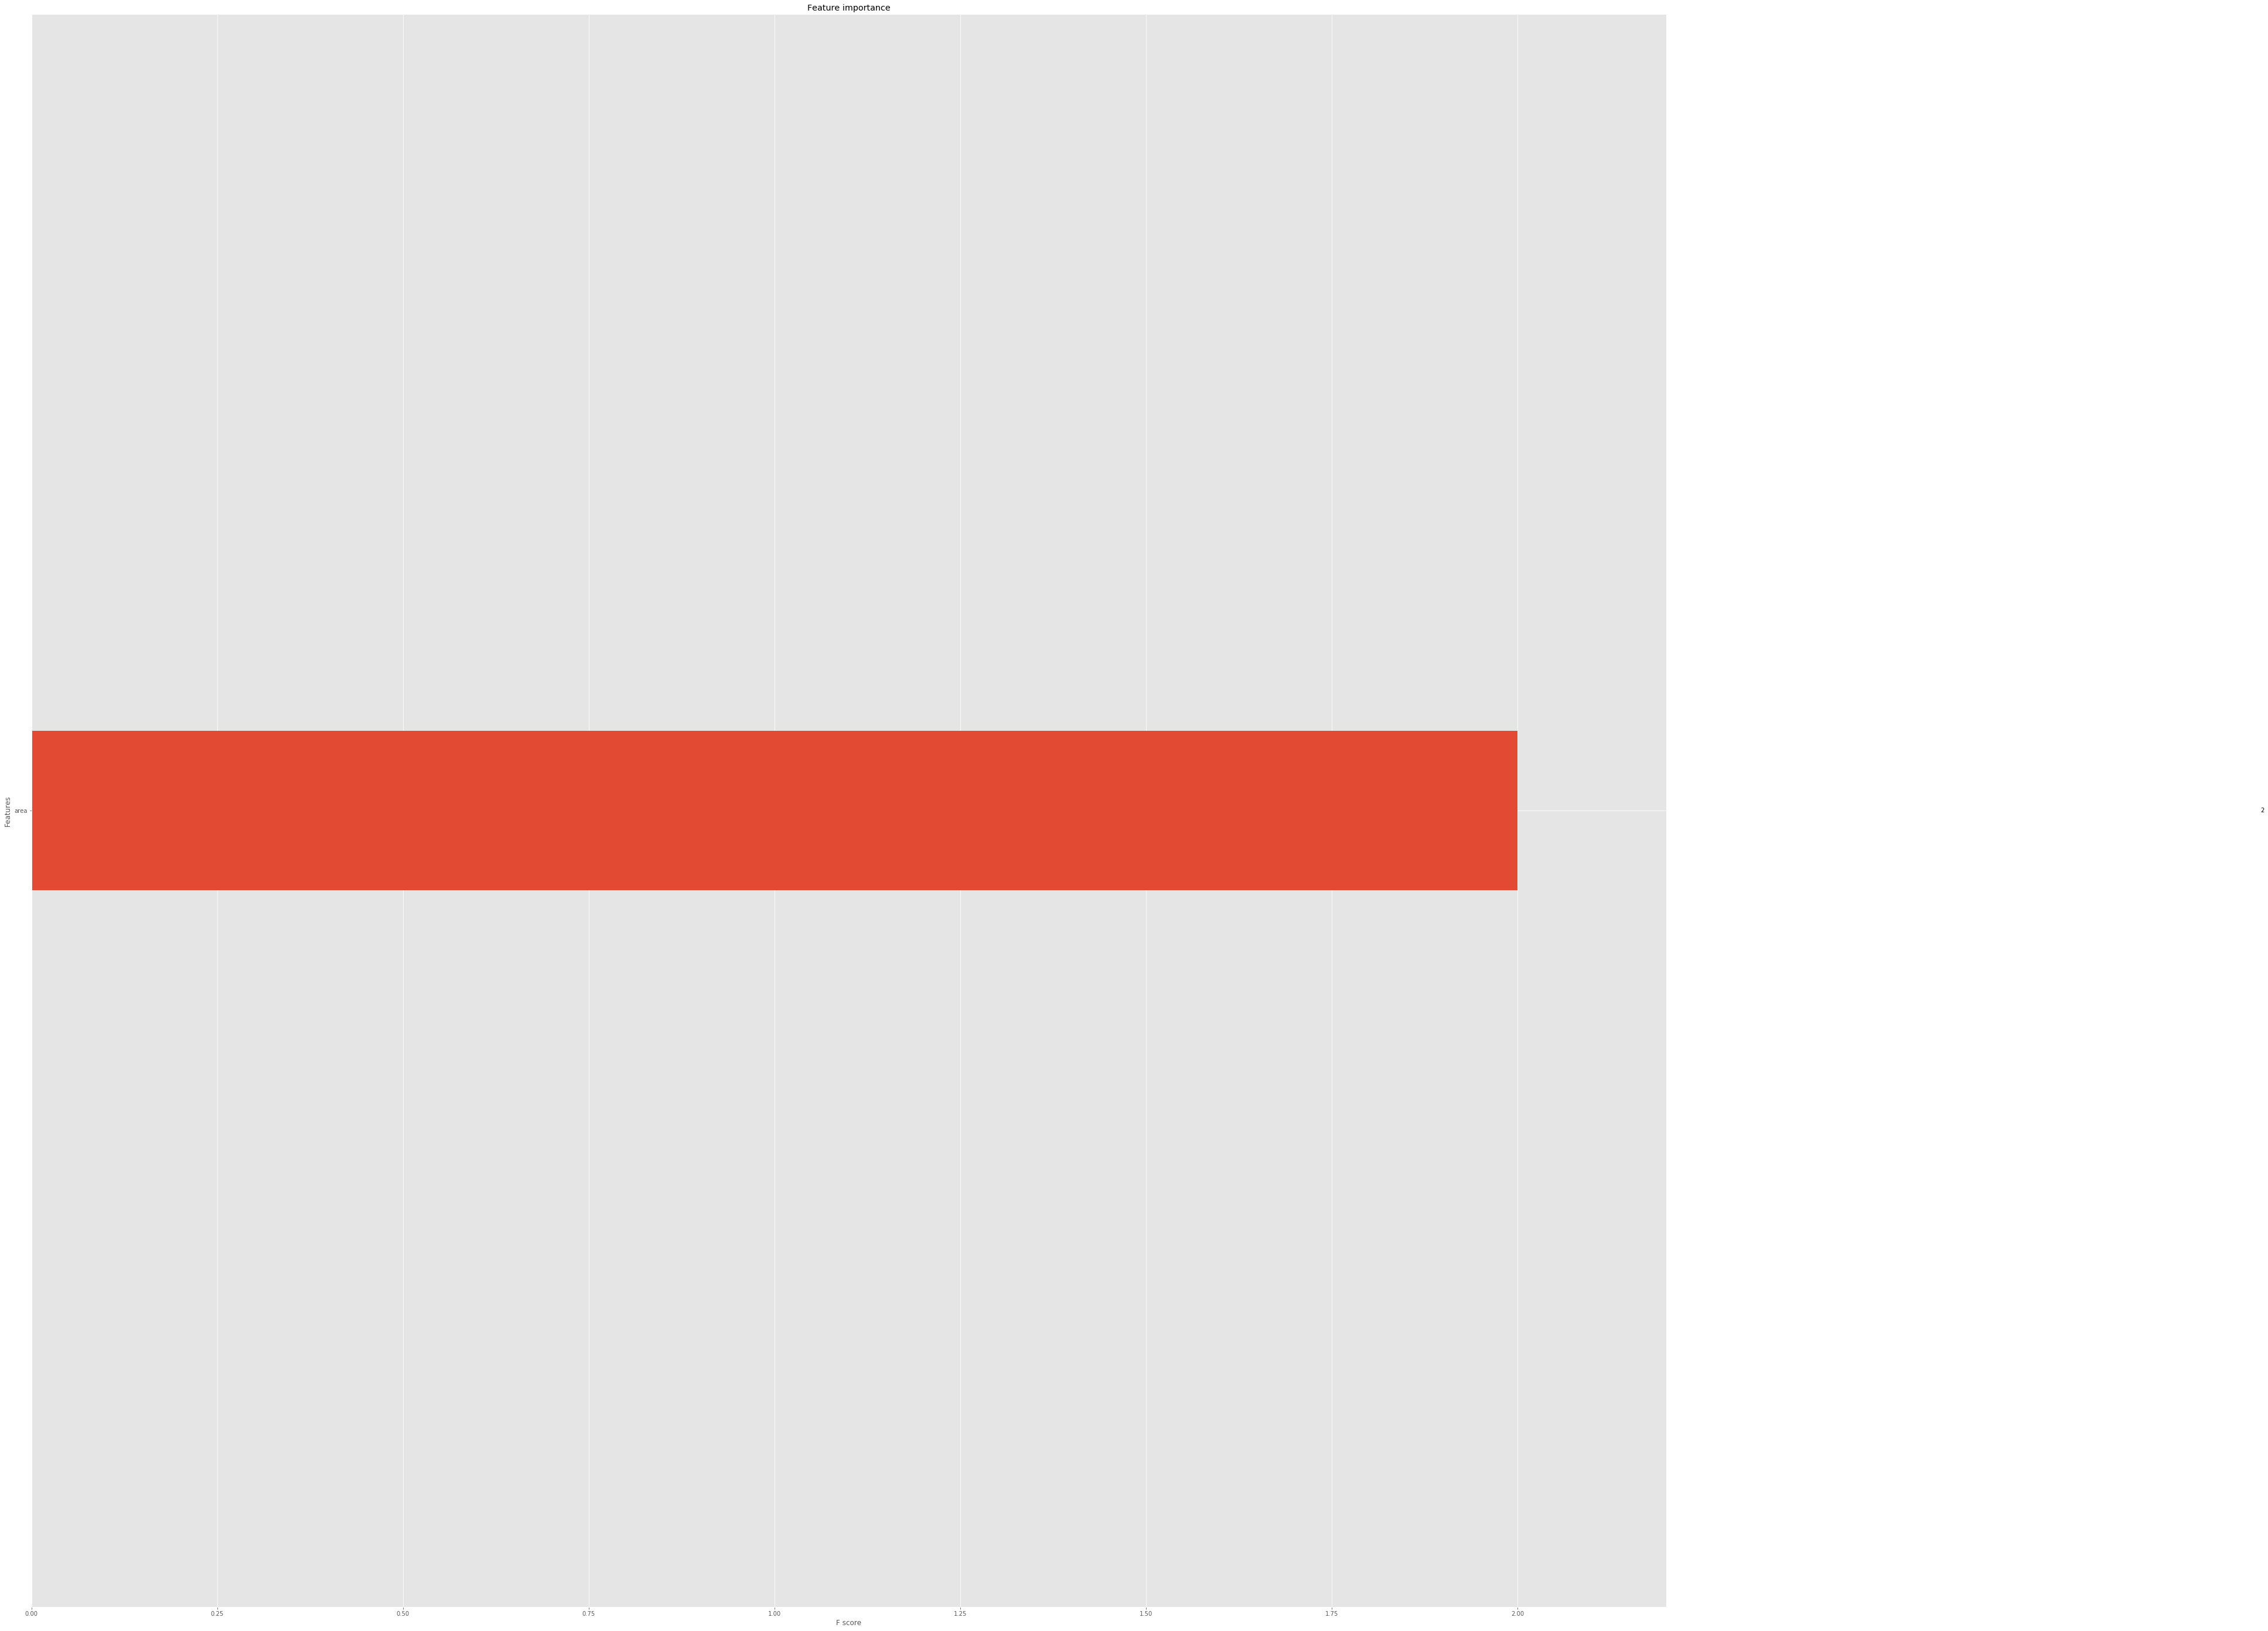

In [51]:
xgboost.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [52]:
plot_importance(xg_reg, max_num_features=10)

NameError: name 'plot_importance' is not defined

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

data_dmatrix = xgb.DMatrix(data=X,label=y)

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


In [ ]:
data(agaricus.train)

bst <- xgboost(data = agaricus.train$data, label = agaricus.train$label, max_depth = 3,
               eta = 1, nthread = 2, nrounds = 2, objective = "binary:logistic")

importance_matrix <- xgb.importance(colnames(agaricus.train$data), model = bst)

xgb.plot.importance(importance_matrix, rel_to_first = TRUE, xlab = "Relative importance")

(gg <- xgb.ggplot.importance(importance_matrix, measure = "Frequency", rel_to_first = TRUE))
gg + ggplot2::ylab("Frequency")
        

In [ ]:
# Create instace
xgb = xgboost.XGBRegressor(objective ='reg:squarederror')

# Fit the model on the training set
model_xgb = xgb.fit(X_train, y_train)

model_xgb.get_booster().get_score(importance_type='weight')


In [ ]:
xgb.plot_importance(model_xgb)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
model_xgb.feature_importances_

In [ ]:
xgb.plot_importance(bst, importance_type = 'gain', )



In [ ]:
data(agaricus.train)

bst <- xgboost(data = agaricus.train$data, label = agaricus.train$label, max_depth = 3,
               eta = 1, nthread = 2, nrounds = 2, objective = "binary:logistic")

importance_matrix <- xgb.importance(colnames(agaricus.train$data), model = bst)

xgb.plot.importance(importance_matrix, rel_to_first = TRUE, xlab = "Relative importance")

(gg <- xgb.ggplot.importance(importance_matrix, measure = "Frequency", rel_to_first = TRUE))
gg + ggplot2::ylab("Frequency")

## 5.2 Training

We first define a rmse evaluation function

In [69]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

model_score = {}

### 5.2.1 Linear Regression
Sometimes, simple models, outperformed more complex models like Random Forest and xgboost, especially on small datasets.

In [79]:
# Create instace
model_lr = linear_model.LinearRegression()

# Fit the model on the training set
model_lr.fit(X_train, y_train)

# Predict
y_pred_lr_train = model_lr.predict(X_train)

# Test
y_pred_lr_test = model_lr.predict(X_test)

# Results
print("LinearRegression Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_lr_train)))
print("LinearRegression Test set RMSE: : {:.4f}".format(rmse(y_test, y_pred_lr_test)))
#print("LinearRegression Training set R^2: : {:.3f}".format(r2_score(y_train, y_pred_lr_train)))
#print("LinearRegression Training set R^2: : {:.3f}".format(r2_score(y_test, y_pred_lr_test)))

# Add to the final comparison dictionary
model_score['linreg'] = rmse(y_test, y_pred_lr_test)

LinearRegression Training set RMSE: : 0.1343
LinearRegression Test set RMSE: : 0.1609
LinearRegression Training set R^2: : 0.809
LinearRegression Training set R^2: : 0.752


{'linreg': 0.1608899730782562, 'lasso': 0.16218213388630406}

### 5.2.2 Lasso

Compute the cross-validation score with the default hyper-parameters

In [134]:
# Create instace
lassoCV = LassoCV(alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100])

# Fit the model on the training set
model_lasso = lassoCV.fit(X_train, y_train)
alpha_l = model_lasso.alpha_
print("Best alpha :", alpha_l)

# Predict
y_pred_lasso_train = model_lasso.predict(X_train)

# Test
y_pred_lasso_test = model_lasso.predict(X_test)

# Results
print("Lasso Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_lasso_train)))
print("Lasso Test set RMSE: : {:.4f}".format(rmse(y_test, y_pred_lasso_test)))

# Add to the final comparison dictionary
model_score['lasso'] = rmse(y_test, y_pred_lasso_test)


coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("\nLasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha : 0.0005
Lasso Training set RMSE: : 0.1352
Lasso Test set RMSE: : 0.1622

Lasso picked 46 variables and eliminated the other 24 variables


C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5498927402874116, tolerance: 0.008175503548553047
  tol, rng, random, positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5498866551652881, tolerance: 0.008175503548553047
  tol, rng, random, positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_de

Automatically created module for IPython interactive environment


C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.771083045771594, tolerance: 7.981255891780199
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.801835681701917, tolerance: 7.981255891780199
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.897868714716452, tolerance: 7.981255891780199
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarnin

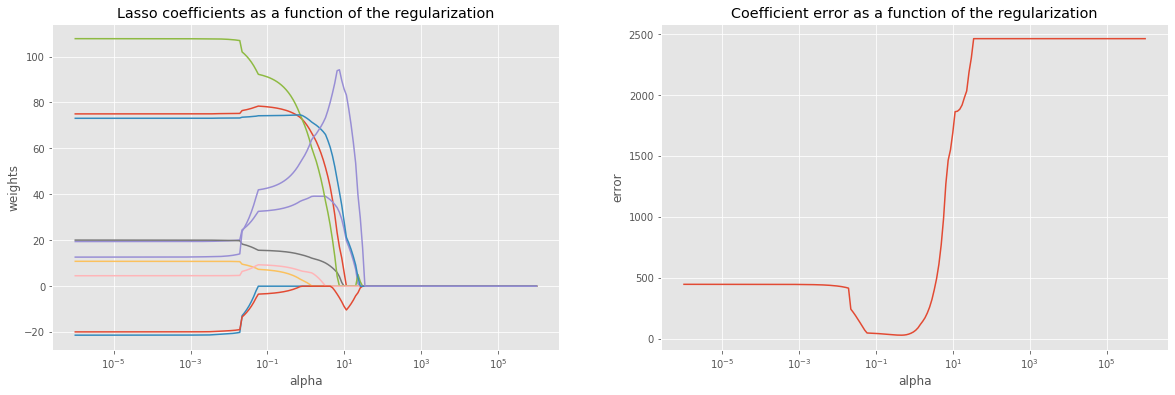

In [135]:
# Author: Kornel Kielczewski -- <kornel.k@plusnet.pl>

print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

clf = Lasso()

X, y, w = make_regression(n_samples=10, n_features=10, coef=True,
                          random_state=1, bias=3.5)

coefs = []
errors = []

alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)
    errors.append(mean_squared_error(clf.coef_, w))

# Display results
plt.figure(figsize=(20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularization')
plt.axis('tight')

plt.show()

### 5.2.3 Ridge

In [131]:
# Create instace
ridgeCV = RidgeCV(alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100])
ridge = Ridge()

# Fit the model on the training set
model_ridge = ridgeCV.fit(X_train, y_train)
alpha = model_ridge.alpha_
print("Best alpha :", alpha)

# Predict
y_pred_ridge_train = model_ridge.predict(X_train)

# Test
y_pred_ridge_test = model_ridge.predict(X_test)

# Results
print("Ridge Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_ridge_train)))
print("Ridge Test set RMSE: : {:.4f}".format(rmse(y_test, y_pred_ridge_test)))

# Add to the final comparison dictionary
model_score['ridge'] = rmse(y_test, y_pred_ridge_test)

Best alpha : 5.0
Ridge Training set RMSE: : 0.1347
Ridge Test set RMSE: : 0.1614


In [138]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


kf = KFold(n_splits=12, random_state=42, shuffle=True)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)



ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

score = cv_rmse(ridge)
ridge_model_full_data = ridge.fit(X_train, y_train)
print("ridge: {:.4f}".format(score.mean()))
model_score['ridge'] =  score.mean()


C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge: 0.1404


C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Automatically created module for IPython interactive environment


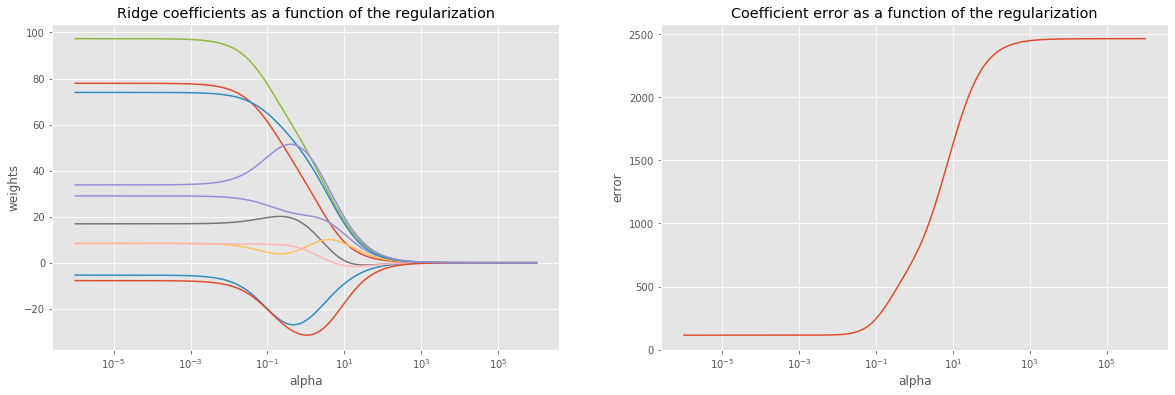

In [132]:
# Author: Kornel Kielczewski -- <kornel.k@plusnet.pl>

print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

clf = Ridge()

X, y, w = make_regression(n_samples=10, n_features=10, coef=True,
                          random_state=1, bias=3.5)

coefs = []
errors = []

alphas = np.logspace(-6, 6, 200)

# Train the model with different regularisation strengths
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)
    errors.append(mean_squared_error(clf.coef_, w))

# Display results
plt.figure(figsize=(20, 6))

plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.title('Coefficient error as a function of the regularization')
plt.axis('tight')

plt.show()

In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

for Model in [Ridge, Lasso]:
    model = Model()
    print('%s: %s' % (Model.__name__,
                      cross_val_score(model, X, y).mean()))

Ridge: -3.8318477933148642
Lasso: -25.674962092106327


C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6103370677643296, tolerance: 1.3396236801145374
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8446437827481874, tolerance: 1.3396236801145374
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.103262079563775, tolerance: 1.3396236801145374
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWa

C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.234660059699298, tolerance: 6.253157761890715
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.372604184787349, tolerance: 1.3396236801145374
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.54946354096433, tolerance: 7.487366467040904
  positive)
C:\Users\jerem\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarn

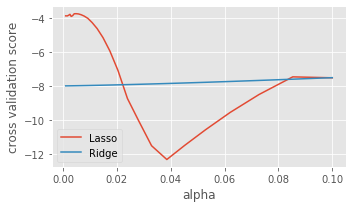

In [87]:
import numpy as np
from matplotlib import pyplot as plt

alphas = np.logspace(-3, -1, 30)

plt.figure(figsize=(5, 3))

for Model in [Lasso, Ridge]:
    scores = [cross_val_score(Model(alpha), X, y, cv=3).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

### 5.2.3 Random Forest

In [101]:
# Create instace
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

# Fit the model on the training set
model_rf = rf.fit(X_train, y_train)

# Predict
y_pred_rf_train = model_rf.predict(X_train)

# Test
y_pred_rf_test = model_rf.predict(X_test)

# Results
print("Random Forest Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_rf_train)))
print("Random Forest set RMSE: : {:.4f}".format(rmse(y_test, y_pred_rf_test)))

# Add to the final comparison dictionary
model_score['rf'] = rmse(y_test, y_pred_rf_test)

Random Forest Training set RMSE: : 0.0502
Random Forest set RMSE: : 0.1527


### 5.2.4 Gradient Boosting Regressor

In [105]:
# Create instace
gbr = GradientBoostingRegressor()

# Fit the model on the training set
model_gbr = gbr.fit(X_train, y_train)

# Predict
y_pred_gbr_train = model_gbr.predict(X_train)

# Test
y_pred_gbr_test = model_gbr.predict(X_test)

# Results
print("Light Gradient Boosting Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_gbr_train)))
print("Light Gradient Boosting set RMSE: : {:.4f}".format(rmse(y_test, y_pred_gbr_test)))

# Add to the final comparison dictionary
model_score['gbr'] = rmse(y_test, y_pred_gbr_test)

Light Gradient Boosting Training set RMSE: : 0.0989
Light Gradient Boosting set RMSE: : 0.1572


### 5.2.4 Light Gradient Boosting Regressor

In [106]:
# Create instace
lightgbm = LGBMRegressor()

# Fit the model on the training set
model_lgbm = lightgbm.fit(X_train, y_train)

# Predict
y_pred_lgbm_train = model_lgbm.predict(X_train)

# Test
y_pred_lgbm_test = model_lgbm.predict(X_test)

# Results
print("Light Gradient Boosting Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_lgbm_train)))
print("Light Gradient Boosting set RMSE: : {:.4f}".format(rmse(y_test, y_pred_lgbm_test)))

# Add to the final comparison dictionary
model_score['lgbm'] = rmse(y_test, y_pred_lgbm_test)

Light Gradient Boosting Training set RMSE: : 0.0612
Light Gradient Boosting set RMSE: : 0.1461


### 5.2.4 Extreme Gradient Boosting Regressor

In [107]:
# Create instace
xgb = xgboost.XGBRegressor(objective ='reg:squarederror')

# Fit the model on the training set
model_xgb = xgb.fit(X_train, y_train)

# Predict
y_pred_xgb_train = model_xgb.predict(X_train)

# Test
y_pred_xgb_test = model_xgb.predict(X_test)

# Results
print("Light Gradient Boosting Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_xgb_train)))
print("Light Gradient Boosting set RMSE: : {:.4f}".format(rmse(y_test, y_pred_xgb_test)))

# Add to the final comparison dictionary
model_score['xgb'] = rmse(y_test, y_pred_xgb_test)

Light Gradient Boosting Training set RMSE: : 0.1038
Light Gradient Boosting set RMSE: : 0.1601


### 5.2.5 AdaBoost

In [89]:
# Create instace
adab = AdaBoostRegressor()

# Fit the model on the training set
model_adab = adab.fit(X_train, y_train)

# Predict
y_pred_adb_train = model_adab.predict(X_train)

# Test
y_pred_adb_test = model_adab.predict(X_test)

# Results
print("Random Forest Training set RMSE: : {:.4f}".format(rmse(y_train, y_pred_adb_train)))
print("Random Forest set RMSE: : {:.4f}".format(rmse(y_test, y_pred_adb_test)))

# Add to the final comparison dictionary
model_score['adb'] = rmse(y_test, y_pred_adb_test)

Random Forest Training set RMSE: : 0.1484
Random Forest set RMSE: : 0.1732


Well, there is some overfitting in the model, as it performs much worse on OOB sample and worse on the validation set. But let’s say it is good enough and move forward to feature importances (measured on the training set performance). Some of the approaches can also be used for validation/OOB sets, to gain further interpretability on the unseen data.

In [ ]:
pd.Series(model_score).sort_values(ascending=True)

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
#plt.xlabel('Relative Importance')

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=df.columns)
feat_importances.nlargest(70).plot(kind='barh')

## 5.3 Hyperparameter optimisation
Each machine learning algorithm has a wide number of parameters that are used to control the learning process. These parameters can be changed and depending on the data set can result in an increase in performance for the model. The process of finding the best set of parameters for an algorithm and data set is known as hyperparameter optimisation.
We know from the code we ran in the last section that the random forest classifier performed best on the data set we are using. If you look at the documentation for this model you will see that there are many parameters that can be tuned for this algorithm.

A common method to use for hyperparameter optimisation is known as grid search. Scikit-learn provides a function to perform this called GridSearchCV. We need to pass this function a grid in the form of a python dictionary containing the parameter names and the corresponding list of parameters. This then becomes the parameter space in which the function will search.
The function will then build a model for every combination of parameters for the given classifier. Once this has been performed you will be able to access the results in the form of the best model and the best parameter combination.
For simplicity, in the example below I have chosen to tune only four parameters. They are as follows:
- n_estimators: the number of trees in the model.
- max_depth: the maximum depth of the tree.
- min_samples_split: the minimum number of data points in a node before the node is split.
- min_samples_leaf: the minimum amount of data points in each leaf.
The code below performs hyperparameter tuning and prints both the best model score and parameter combination.

In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid)
best_model = grid_search.fit(X_train, y_train)
print(round(best_model.score(X_test, y_test),2))
print(best_model.best_params_)

Use Ensemble models: Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. Particularly if your models are learning are doing well on different things (ex: one is good for classifying negative examples and another at classifying positive examples) combining both of them will often yield to better results. Our final model was a combination of My models (most of them xgboost) and Steven’s models (RF, SVR, GBM, ElasticNet, Lasso and others). Without going into more details what I can tell you is that combining our models we got an improvement.

In [67]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:    7.6s finished


0.8134253654919973
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


## 5.4 Final evaluation

Finally, we use the best model to predict labels on the test set and print a classification report to evaluate its performance in detail. We can see that overall the performance has vastly improved from the baseline model.

In [ ]:
from sklearn.metrics import classification_report
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))